In [27]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt

In [28]:
df = pd.read_csv("../data/merged.csv", index_col=0)
df = df[pd.to_datetime(df.index, errors='coerce').notna()]
df.index = pd.to_datetime(df.index)
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna()

print("Data shape:", df.shape)
print("Columns:", df.columns)
print(df.head())


Data shape: (2514, 2)
Columns: Index(['ES=F', 'NQ=F'], dtype='object')
               ES=F     NQ=F
Price                       
2015-01-02  2046.25  4214.25
2015-01-05  2016.00  4161.75
2015-01-06  1994.50  4102.25
2015-01-07  2019.50  4151.50
2015-01-08  2055.00  4232.25


/var/folders/jb/pk23bkyn13b2jj0ptqjmbskr0000gn/T/ipykernel_13239/2770259960.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = df[pd.to_datetime(df.index, errors='coerce').notna()]


In [29]:
def engle_granger_test(y, x):
    test_stat, p_value, _ = coint(y, x)
    return p_value

In [30]:
def find_cointegrated_pairs(df, threshold=0.05):
    """
    Loops over all pairs of columns in df and tests for cointegration.
    Returns list of cointegrated pairs and DataFrame summary.
    """
    symbols = df.columns
    n = len(symbols)
    pairs = []
    summary = []

    for i in range(n):
        for j in range(i+1, n):
            y = df[symbols[i]]
            x = df[symbols[j]]
            print(f"\nTesting {symbols[i]} vs {symbols[j]}...")

            try:
                p = engle_granger_test(y, x)
                print(f"p-value: {p:.4f}")
            except Exception as e:
                print(f"Error testing pair {symbols[i]} & {symbols[j]}: {e}")
                p = np.nan

            summary.append({
                "y": symbols[i],
                "x": symbols[j],
                "p_value": p
            })

            if p < threshold:
                pairs.append((symbols[i], symbols[j], p))

    summary_df = pd.DataFrame(summary)
    return pairs, summary_df


In [31]:
# Run
pairs, summary_df = find_cointegrated_pairs(df)

# Output results
print("\nCointegration summary:")
print(summary_df)

# Save summary CSV
summary_df.to_csv("../outputs/cointegration_summary.csv", index=False)
print("\nSaved cointegration_summary.csv")

# Show cointegrated pairs
if pairs:
    print("\nCointegrated pairs (p < 0.06):")
    for p in pairs:
        print(p)
else:
    print("\nNo cointegrated pairs found.")


Testing ES=F vs NQ=F...
p-value: 0.1603

Cointegration summary:
      y     x   p_value
0  ES=F  NQ=F  0.160295

Saved cointegration_summary.csv

No cointegrated pairs found.


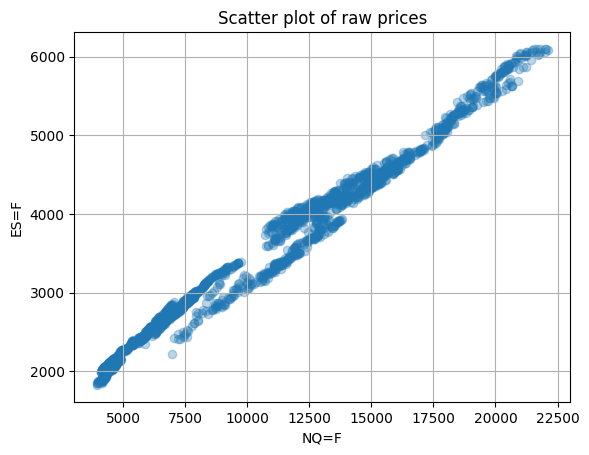

In [32]:
import matplotlib.pyplot as plt
plt.scatter(df["NQ=F"], df["ES=F"], alpha=0.3)
plt.xlabel("NQ=F")
plt.ylabel("ES=F")
plt.title("Scatter plot of raw prices")
plt.grid(True)
plt.show()


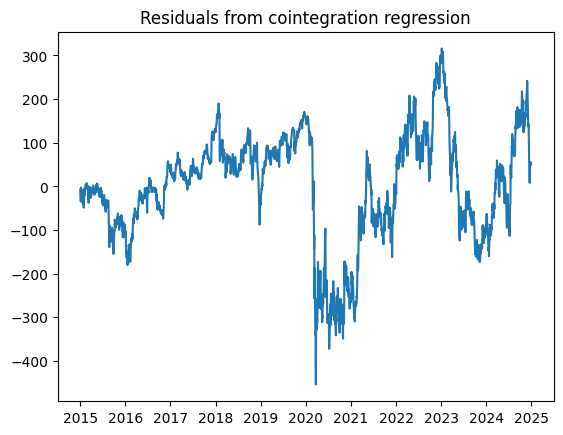

ADF Statistic: -2.8160221494996645
p-value: 0.05602131425778096


In [33]:
import statsmodels.api as sm

y = df['ES=F']
x = df['NQ=F']
x_const = sm.add_constant(x)
model = sm.OLS(y, x_const).fit()
residuals = model.resid

plt.plot(residuals)
plt.title("Residuals from cointegration regression")
plt.show()

from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(residuals)
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

